<a href="https://colab.research.google.com/github/nudojacopo/thesis/blob/main/src/SYN/synthetic_signals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import

In [1]:
!git clone https://github.com/nudojacopo/thesis.git
from google.colab import drive
drive.mount('/content/drive')
root='/content/'
import sys
module_path = root+'thesis/src/SYN'
sys.path.append(module_path)
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
!pip install powerlaw
from SYN_package.functions import *
from SYN_package.estimate_parameters import *
import json
from scipy import stats
import random
from scipy.stats import chi2
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
import powerlaw
import warnings

Cloning into 'thesis'...
remote: Enumerating objects: 1705, done.
remote: Counting objects: 100% (432/432), done.
remote: Compressing objects: 100% (262/262), done.
remote: Total 1705 (delta 253), reused 261 (delta 167), pack-reused 1273
Receiving objects: 100% (1705/1705), 76.33 MiB | 14.16 MiB/s, done.
Resolving deltas: 100% (1074/1074), done.
Mounted at /content/drive


## Set up

In [2]:
# Choose settings for the parameters part
estimate_parameters=False # to estimate parameters
name_parameters='params_dict_trial' # good for ZIE separated

n=500 # number of threads
h=100 # number of hours considered

## Prepare Data

In [3]:
rd=pd.read_csv('/content/drive/MyDrive/thesis/data/reddit/reddit_PRO.csv')
fb=pd.read_csv('/content/drive/MyDrive/thesis/data/facebook/facebook_news_PRO.csv')
vo=pd.read_csv('/content/drive/MyDrive/thesis/data/voat/voat_PRO.csv')
gb=pd.read_csv('/content/drive/MyDrive/thesis/data/gab/gab_PRO.csv')


fb=filter_first_h(fb,h)
gb=filter_first_h(gb,h)
rd=filter_first_h(rd,h)
vo=filter_first_h(vo,h)

names = ['gb','rd','fb','vo']
datas = [gb,rd,fb,vo]

## Search parameters

In [4]:
if estimate_parameters:
  params_dict = process_social_platform(names, datas)
  file_path = '/content/drive/MyDrive/thesis/data/parameters/'+name_parameters+'.json'
  os.makedirs(os.path.dirname(file_path), exist_ok=True)
  with open(file_path, 'w') as file:
      json.dump(params_dict, file)
else:
  with open('/content/drive/MyDrive/thesis/data/parameters/'+name_parameters+'.json', 'r') as file:
    params_dict = json.load(file)

## Simulate synthetic data

In [6]:
time_intervals = np.arange(0, 1, 0.05)
'''
all_dfs = []
for i, df in enumerate(datas):
    social = names[i]
    parameters = params_dict[social]

    simulated_t, observed_t = simulate_data_M2(df, parameters, num_threads=n, activate_tqdm=True)
    globals()[f"{social}s_M2"] = simulated_t
    globals()[f"{social}o_M2"] = observed_t

    simulated_t_ECDF = calculate_ECDF(simulated_t, time_intervals)
    simulated_t_ECDF['Platform'] = social
    simulated_t_ECDF['Style'] = 'Simulated'

    observed_t_ECDF = calculate_ECDF(observed_t, time_intervals)
    observed_t_ECDF['Platform'] = social
    observed_t_ECDF['Style'] = 'Observed'

    df_platform = pd.concat([simulated_t_ECDF, observed_t_ECDF], ignore_index=True)
    all_dfs.append(df_platform)

df_all_M2 = pd.concat(all_dfs, ignore_index=True)'''

all_dfs = []
for i, df in enumerate(datas):
    social = names[i]
    parameters = params_dict[social]

    simulated_t, observed_t = simulate_data(df, parameters, activate_tqdm=True, num_threads=n)# peensaree a come limitar i valori dell funzionee IAT senza crear break infiniti
    globals()[f"{social}s_M1"] = simulated_t
    globals()[f"{social}o_M1"] = observed_t

    simulated_t_ECDF = calculate_ECDF(simulated_t, time_intervals)
    simulated_t_ECDF['Platform'] = social
    simulated_t_ECDF['Style'] = 'Simulated'

    observed_t_ECDF = calculate_ECDF(observed_t, time_intervals)
    observed_t_ECDF['Platform'] = social
    observed_t_ECDF['Style'] = 'Observed'

    df_platform = pd.concat([simulated_t_ECDF, observed_t_ECDF], ignore_index=True)
    all_dfs.append(df_platform)

df_all_M1 = pd.concat(all_dfs, ignore_index=True)


Processing DataFrame: 100%|██████████| 500/500 [00:19<00:00, 26.21it/s]


# Signals

## Dynamic

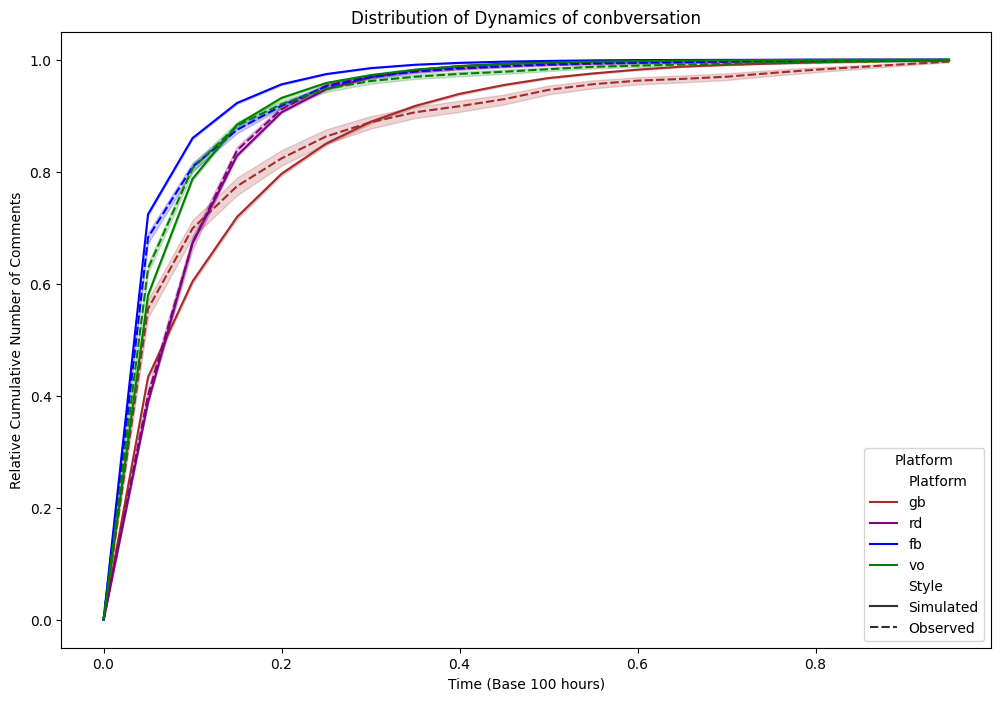

"df_line1 = df_all_M1[df_all_M1['Style'] == 'Simulated']\ndf_line2 = df_all_M1[df_all_M1['Style'] == 'Observed']\ndf_line1 = df_line1.set_index(['Time Grid Value', 'Platform'])\ndf_line2 = df_line2.set_index(['Time Grid Value', 'Platform'])\ndf_merged = df_line1.join(df_line2, lsuffix='_line1', rsuffix='_line2')\nmse_per_platform_M1 = df_merged.groupby('Platform').apply(lambda x: np.mean((x['Share_line1'] - x['Share_line2'])**2))"

In [8]:
# Prepare data
palette = {'rd': 'purple', 'vo': 'green', 'fb': 'blue', 'yt': 'red','gb':'brown'}
df_all = df_all_M1.sort_values(by='Style')

# Plot comment arrival dynamic
plt.figure(figsize=(12, 8))
sns.lineplot(data=df_all_M1, x='Time Grid Value', y='Share', hue='Platform', style='Style', err_style='band', errorbar=('ci', 80), palette=palette)
plt.title('Distribution of Dynamics of conbversation')
plt.ylabel('Relative Cumulative Number of Comments')
plt.xlabel('Time (Base 100 hours)')
plt.grid(False)
plt.legend(title='Platform')
plt.show()

# Calculate Loss
'''df_line1 = df_all_M1[df_all_M1['Style'] == 'Simulated']
df_line2 = df_all_M1[df_all_M1['Style'] == 'Observed']
df_line1 = df_line1.set_index(['Time Grid Value', 'Platform'])
df_line2 = df_line2.set_index(['Time Grid Value', 'Platform'])
df_merged = df_line1.join(df_line2, lsuffix='_line1', rsuffix='_line2')
mse_per_platform_M1 = df_merged.groupby('Platform').apply(lambda x: np.mean((x['Share_line1'] - x['Share_line2'])**2))'''

In [ ]:
import pandas as pd
from scipy import stats
social='fb'
# Estrazione dei dati pertinenti
simulated_shares = df_all_M1[(df_all_M1['Style'] == 'Simulated') & (df_all_M1['Platform'] ==social)]['Share']
observed_shares = df_all_M1[(df_all_M1['Style'] == 'Observed') & (df_all_M1['Platform'] ==social)]['Share']

# Esecuzione del test di Kolmogorov-Smirnov
ks_stat, p_value = stats.ks_2samp(simulated_shares, observed_shares)

ks_stat, p_value


(0.331, 2.208483755167228e-97)

### Interaction Model - M2

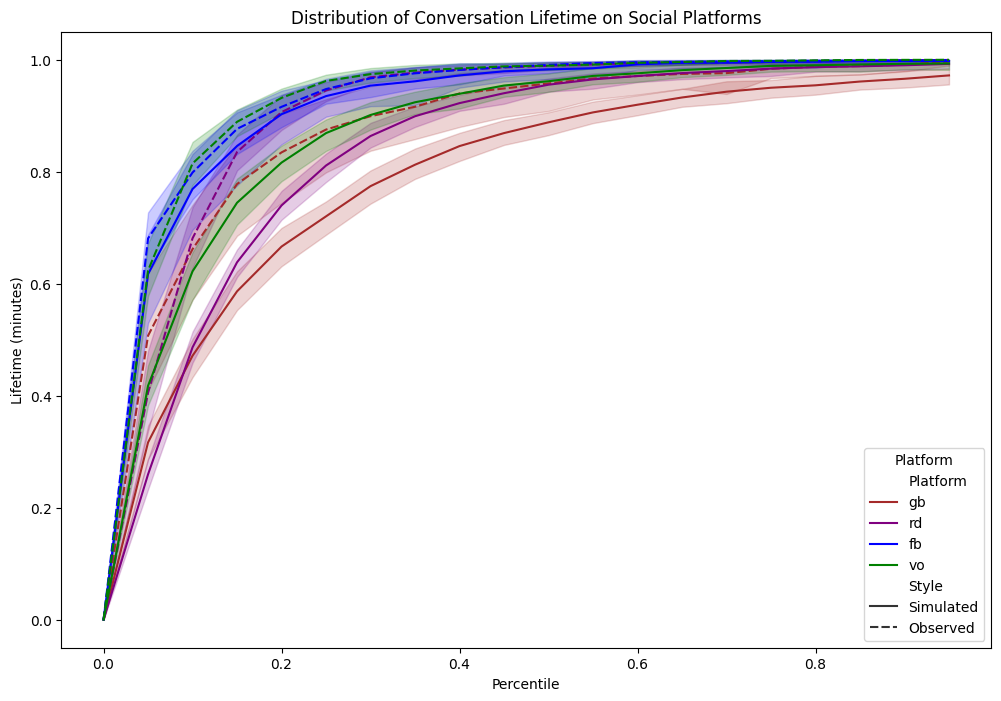

Platform
fb    0.014071
gb    0.040254
rd    0.016738
vo    0.013692
dtype: float64


In [ ]:
# Prepare data
palette = {'rd': 'purple', 'vo': 'green', 'fb': 'blue', 'yt': 'red','gb':'brown'}
df_all = df_all_M2.sort_values(by='Style')

# Plot comment arrival dynamic
plt.figure(figsize=(12, 8))
sns.lineplot(data=df_all_M2, x='Time Grid Value', y='Share', hue='Platform', style='Style', err_style='band', errorbar=('ci', 100), palette=palette)
plt.title('Distribution of Conversation Lifetime on Social Platforms')
plt.ylabel('Lifetime (minutes)')
plt.xlabel('Percentile')
plt.grid(False)
plt.legend(title='Platform')
plt.show()

# Calculate Loss
df_line1 = df_all_M2[df_all_M2['Style'] == 'Simulated']
df_line2 = df_all_M2[df_all_M2['Style'] == 'Observed']
df_line1 = df_line1.set_index(['Time Grid Value', 'Platform'])
df_line2 = df_line2.set_index(['Time Grid Value', 'Platform'])
df_merged = df_line1.join(df_line2, lsuffix='_line1', rsuffix='_line2')
mse_per_platform_M2 = df_merged.groupby('Platform').apply(lambda x: np.mean((x['Share_line1'] - x['Share_line2'])**2))
print(mse_per_platform_M2)

### Comparison Dyanamics Loss

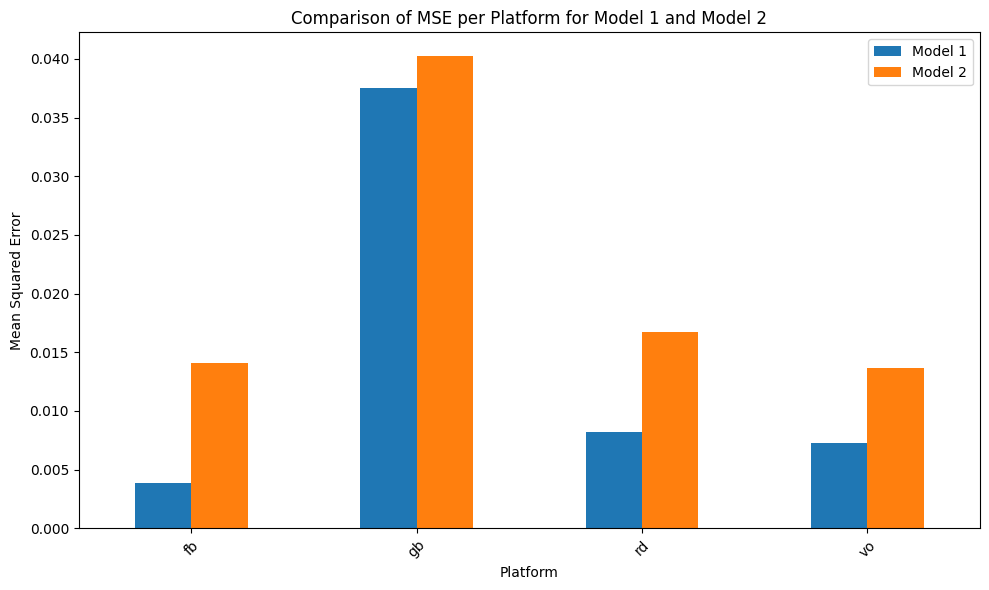

  Platform        M1        M2
0       fb  0.003831  0.014071
1       gb  0.037518  0.040254
2       rd  0.008220  0.016738
3       vo  0.007291  0.013692


In [ ]:
mse_df = pd.DataFrame({
    'M1': mse_per_platform_M1,
    'M2': mse_per_platform_M2
}).reset_index()

fig, ax = plt.subplots(figsize=(10, 6))

mse_df.plot(kind='bar', x='Platform', ax=ax)

plt.title('Comparison of MSE per Platform for Model 1 and Model 2')
plt.xlabel('Platform')
plt.ylabel('Mean Squared Error')
plt.xticks(rotation=45)
plt.legend(['Model 1', 'Model 2'])
plt.tight_layout()

plt.show()
print(mse_df)

## Partecipation

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # tqdm for progress bar

# Assuming rd, fb, vo, yt are your DataFrames

# Add 'platform' column to each DataFrame
rdo_M1['platform'] = 'Reddit'
voo_M1['platform'] = 'Voat'
fbo_M1['platform'] = 'Facebook'
gbo_M1['platform'] = 'Gab'
# Combine all DataFrames into a single DataFrame
all_data = []

# Process each dataset individually
for df in tqdm([rdo_M1,  voo_M1,fbo_M1,gbo_M1]):#yto
    df['number_of_comments'] = df.groupby('post_id')['post_id'].transform('count')
    df['sequential_position'] = df.groupby('post_id')['temporal_distance_birth_base_100h'].rank(method='first')

    # Determine the number of bins
    num_bins = 30

    # Calculate the bin of position
    df['bin_of_position'] = ((df['sequential_position'] - 1) / df['number_of_comments'] * num_bins).astype(int) + 1
    df['first_comment']=df['sequential_number_of_comment_by_user_in_thread']==1
    # Group by 'bin_of_position', 'post_id', and calculate unique users per post
    df['first_comment'] = df.groupby(['bin_of_position', 'post_id'])['first_comment'].transform('mean')
    all_data.append(df)
all_data = pd.concat(all_data, ignore_index=True)
# Aggregate data across all datasets
agg_activity_obs = all_data.groupby(['platform', 'bin_of_position', 'post_id'])['first_comment'].mean().reset_index()


100%|██████████| 4/4 [00:00<00:00, 10.22it/s]


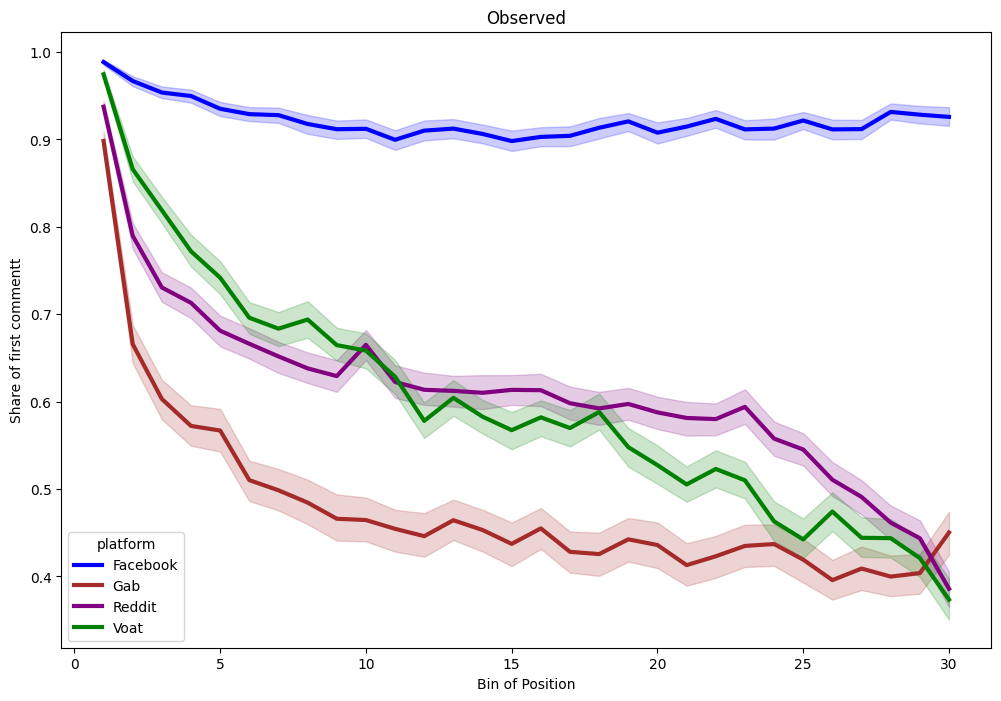

In [14]:
plt.figure(figsize=(12, 8))
sns.lineplot(
    data=agg_activity_obs,
    x='bin_of_position',
    y='first_comment',
    hue='platform',  # Different line for each platform
    estimator='mean',  # or 'sum', 'median', etc. depending on your aggregation preference
    errorbar=('ci', 80),  # 99.999% confidence interval
    linewidth=3,
    palette={'Reddit': 'purple', 'Voat': 'green', 'Facebook': 'blue','Gab': 'brown'}#,'YouTube':'red'}  # Custom palette with specified colors
)
plt.title('Observed')
plt.ylabel('Share of first commentt')
plt.xlabel('Bin of Position')
plt.grid(False)
plt.show()


#### M1

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # tqdm for progress bar

# Assuming rd, fb, vo, yt are your DataFrames

# Add 'platform' column to each DataFrame
rds_M1['platform'] = 'Reddit'
vos_M1['platform'] = 'Voat'
fbs_M1['platform'] = 'Facebook'
gbs_M1['platform'] = 'Gab'
# Combine all DataFrames into a single DataFrame
all_data = []

# Process each dataset individually
for df in tqdm([rds_M1,  vos_M1,fbs_M1,gbs_M1]):#yto
    df['number_of_comments'] = df.groupby('post_id')['post_id'].transform('count')
    df['sequential_position'] = df.groupby('post_id')['temporal_distance_birth_base_100h'].rank(method='first')

    # Determine the number of bins
    num_bins = 30

    # Calculate the bin of position
    df['bin_of_position'] = ((df['sequential_position'] - 1) / df['number_of_comments'] * num_bins).astype(int) + 1

    df['first_comment']=df['sequential_number_of_comment_by_user_in_thread']==1
    # Group by 'bin_of_position', 'post_id', and calculate unique users per post
    df['first_comment'] = df.groupby(['bin_of_position', 'post_id'])['first_comment'].transform('mean')
    all_data.append(df)
all_data = pd.concat(all_data, ignore_index=True)
# Aggregate data across all datasets
agg_activity_sim_M1 = all_data.groupby(['platform', 'bin_of_position', 'post_id'])['first_comment'].mean().reset_index()



100%|██████████| 4/4 [00:00<00:00,  5.89it/s]


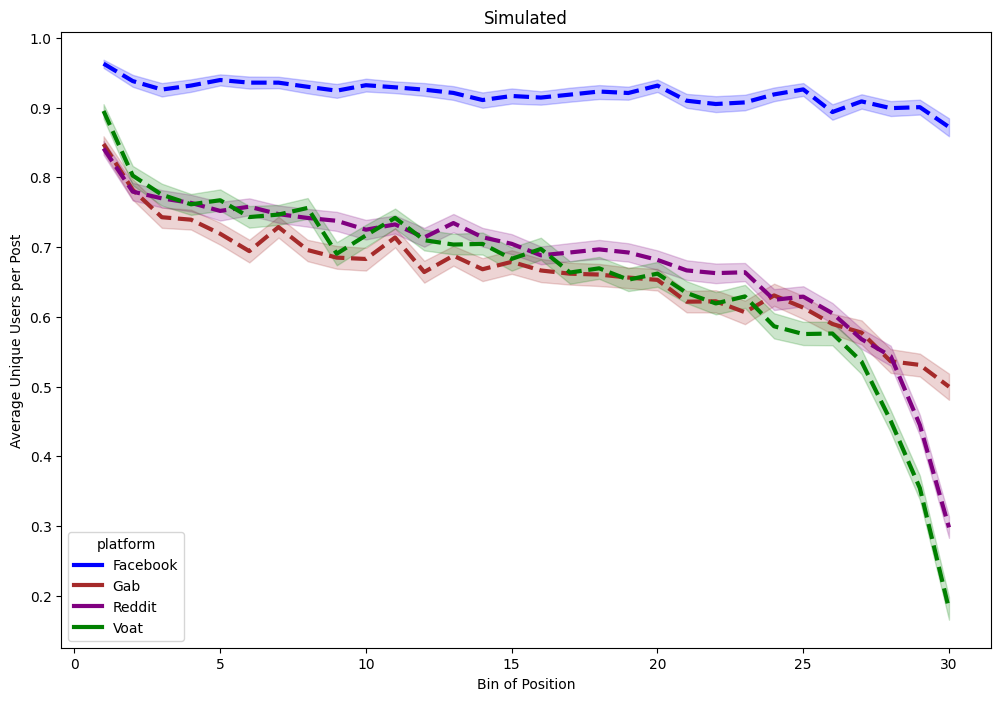

In [13]:
plt.figure(figsize=(12, 8))

# Create the line plot
sns.lineplot(
    data=agg_activity_sim_M1,
    x='bin_of_position',
    y='first_comment',
    hue='platform',  # Different line for each platform
    estimator='mean',  # Aggregation preference
    errorbar=('ci', 80),  # 80% confidence interval
    linewidth=3,
    palette={'Reddit': 'purple', 'Voat': 'green', 'Facebook': 'blue', 'Gab': 'brown'},  # Adding style for dashed line
)

# Manually setting the line style for one of the platforms
lines = plt.gca().get_lines()
for line in lines:
  line.set_linestyle('--')

plt.title('Simulated')
plt.ylabel('Average Unique Users per Post')
plt.xlabel('Bin of Position')
plt.grid(False)

plt.show()


#### M2

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # tqdm for progress bar

# Assuming rd, fb, vo, yt are your DataFrames

# Add 'platform' column to each DataFrame
rds_M2['platform'] = 'Reddit'
vos_M2['platform'] = 'Voat'
fbs_M2['platform'] = 'Facebook'
gbs_M2['platform'] = 'Gab'
# Combine all DataFrames into a single DataFrame
all_data = []

# Process each dataset individually
for df in tqdm([rds_M2,  vos_M2,fbs_M2,gbs_M2]):#yto
    df['number_of_comments'] = df.groupby('post_id')['post_id'].transform('count')
    df['sequential_position'] = df.groupby('post_id')['temporal_distance_birth_base_100h'].rank(method='first')

    # Determine the number of bins
    num_bins = 30

    # Calculate the bin of position
    df['bin_of_position'] = ((df['sequential_position'] - 1) / df['number_of_comments'] * num_bins).astype(int) + 1
    df['first_comment']=df['sequential_number_of_comment_by_user_in_thread']==1
    # Group by 'bin_of_position', 'post_id', and calculate unique users per post
    df['first_comment'] = df.groupby(['bin_of_position', 'post_id'])['first_comment'].transform('mean')
    all_data.append(df)
all_data = pd.concat(all_data, ignore_index=True)
# Aggregate data across all datasets
agg_activity_sim_M2 = all_data.groupby(['platform', 'bin_of_position', 'post_id'])['first_comment'].mean().reset_index()


100%|██████████| 4/4 [00:00<00:00, 56.43it/s]


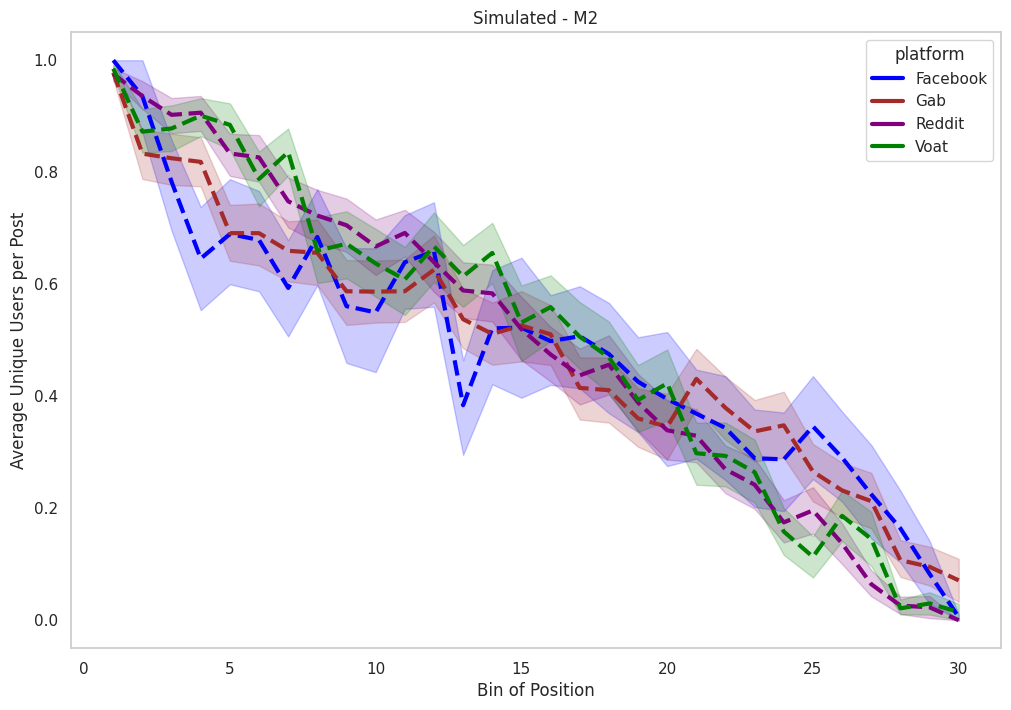

In [ ]:
plt.figure(figsize=(12, 8))

# Create the line plot
sns.lineplot(
    data=agg_activity_sim_M2,
    x='bin_of_position',
    y='first_comment',
    hue='platform',  # Different line for each platform
    estimator='mean',  # Aggregation preference
    errorbar=('ci', 80),  # 80% confidence interval
    linewidth=3,
    palette={'Reddit': 'purple', 'Voat': 'green', 'Facebook': 'blue', 'Gab': 'brown'},  # Adding style for dashed line
)

# Manually setting the line style for one of the platforms
lines = plt.gca().get_lines()
for line in lines:
  line.set_linestyle('--')

plt.title('Simulated - M2')
plt.ylabel('Average Unique Users per Post')
plt.xlabel('Bin of Position')
plt.grid(False)
plt.show()


##### Loss comparison

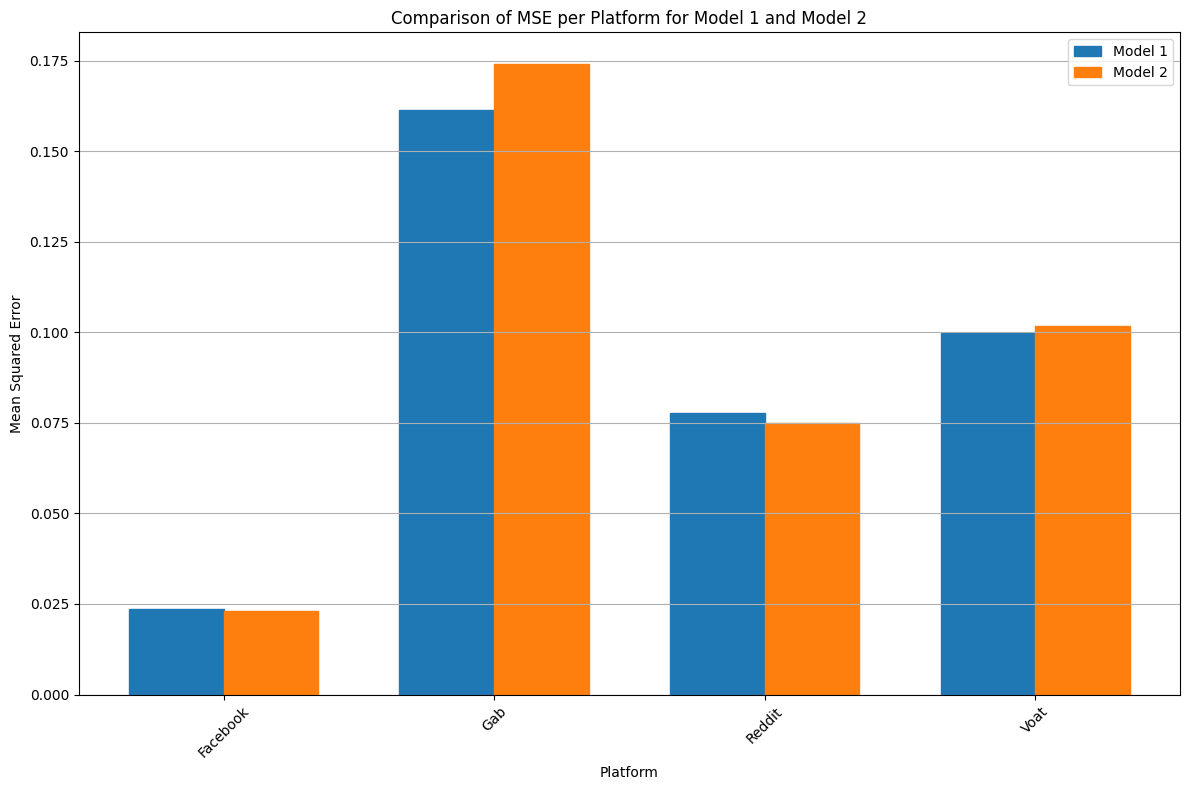

   platform        M1        M2
0  Facebook  0.023623  0.022982
1       Gab  0.161345  0.174158
2    Reddit  0.077784  0.074937
3      Voat  0.099882  0.101882


In [ ]:


# Calculate MSE for each platform for Model 1
df_line1_M1 = agg_activity_sim_M1
df_line2 = agg_activity_obs

df_line1_M1 = df_line1_M1.set_index(['bin_of_position', 'platform'])
df_line2 = df_line2.set_index(['bin_of_position', 'platform'])

df_merged_M1 = df_line1_M1.join(df_line2, lsuffix='_line1', rsuffix='_line2')
mse_per_platform_M1 = df_merged_M1.groupby('platform').apply(
    lambda x: np.mean((x['first_comment_line1'] - x['first_comment_line2'])**2))

# Calculate MSE for each platform for Model 2
df_line1_M2 = agg_activity_sim_M2  # Assuming you have a similar DataFrame for Model 2
df_line1_M2 = df_line1_M2.set_index(['bin_of_position', 'platform'])

df_merged_M2 = df_line1_M2.join(df_line2, lsuffix='_line1', rsuffix='_line2')
mse_per_platform_M2 = df_merged_M2.groupby('platform').apply(
    lambda x: np.mean((x['first_comment_line1'] - x['first_comment_line2'])**2))

# Combine MSE data into a single DataFrame for plotting
mse_df = pd.DataFrame({
    'M1': mse_per_platform_M1,
    'M2': mse_per_platform_M2
}).reset_index()

# Plotting the comparison
fig, ax = plt.subplots(figsize=(12, 8))

# Define colors and edgecolors
colors = ['#1f77b4', '#ff7f0e']
edgecolors = ['#1f77b4', '#ff7f0e']

# Plot bars with custom colors and borders
bar_width = 0.35
index = np.arange(len(mse_df))

bar1 = ax.bar(index, mse_df['M1'], bar_width, color=colors[0], edgecolor=edgecolors[0], label='Model 1')
bar2 = ax.bar(index + bar_width, mse_df['M2'], bar_width, color=colors[1], edgecolor=edgecolors[1], label='Model 2')

# Add labels, title, and legend
ax.set_xlabel('Platform')
ax.set_ylabel('Mean Squared Error')
ax.set_title('Comparison of MSE per Platform for Model 1 and Model 2')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(mse_df['platform'], rotation=45)
ax.legend()

# Add a grid for better readability
ax.yaxis.grid(True)

plt.tight_layout()
plt.show()

print(mse_df)